In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

In [2]:

# Set up for ignoring warnings
import warnings
warnings.filterwarnings("ignore")



In [3]:
# Load data
df = pd.read_csv('fraud_oracle.csv')


In [4]:
# Preliminary investigation
print(df.info())
columns = df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

In [7]:
# Visualizing Fraud Count in dataset
def plot_fraud_count(df, title):
    grouped_df = df.groupby(['FraudFound_P']).count()
    plt.bar(grouped_df.index, height=grouped_df['Month'])
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Classifier')
    plt.show()

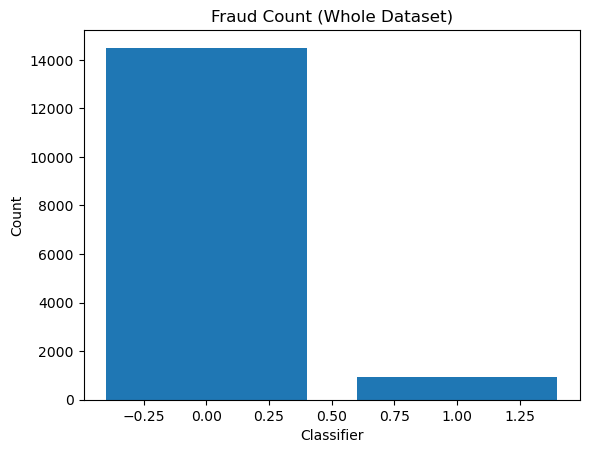

In [8]:
plot_fraud_count(df, 'Fraud Count (Whole Dataset)')


In [9]:
# Balancing the dataset
df_zero = df[df['FraudFound_P'] == 0].sample(n=2000)
df_ones = df[df['FraudFound_P'] == 1]
df_new = pd.concat([df_zero, df_ones])


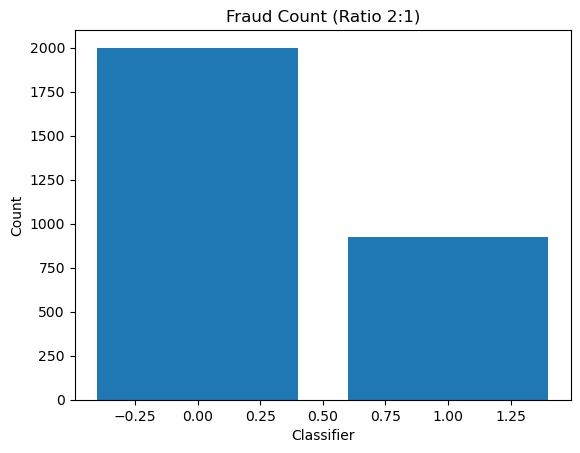

In [10]:
plot_fraud_count(df_new, 'Fraud Count (Ratio 2:1)')


In [12]:
# Encoding categorical columns
label_encoders = {}
for col in columns:
    if df_new[col].dtype == 'object':
        le = LabelEncoder()
        df_new[col] = le.fit_transform(df_new[col])
        label_encoders[col] = le

In [13]:
# Splitting the data into training and testing
x_train, x_test, y_train, y_test = train_test_split(df_new.drop(['FraudFound_P'], axis=1), df_new['FraudFound_P'], train_size=0.7, random_state=42)



In [14]:
# AdaBoostClassifier with DecisionTreeClassifier
dt_fit = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_split=2, min_samples_leaf=1, random_state=42)
ada_fit = AdaBoostClassifier(base_estimator=dt_fit, n_estimators=5000, learning_rate=0.05, random_state=42)
ada_fit.fit(x_train, y_train)


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,
                                                         random_state=42),
                   learning_rate=0.05, n_estimators=5000, random_state=42)

In [15]:
# Model Evaluation
def evaluate_model(model, x_train, y_train, x_test, y_test):
    training_accuracy = accuracy_score(y_train, model.predict(x_train))
    testing_accuracy = accuracy_score(y_test, model.predict(x_test))
    print(f'Training Accuracy: {round(training_accuracy, 3)}')
    print(f'Testing Accuracy: {round(testing_accuracy, 3)}')
    print('\nClassification Report (Test Data):\n', classification_report(y_test, model.predict(x_test)))



In [16]:
evaluate_model(ada_fit, x_train, y_train, x_test, y_test)


Training Accuracy: 1.0
Testing Accuracy: 0.893

Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       606
           1       0.84      0.80      0.82       271

    accuracy                           0.89       877
   macro avg       0.88      0.87      0.87       877
weighted avg       0.89      0.89      0.89       877



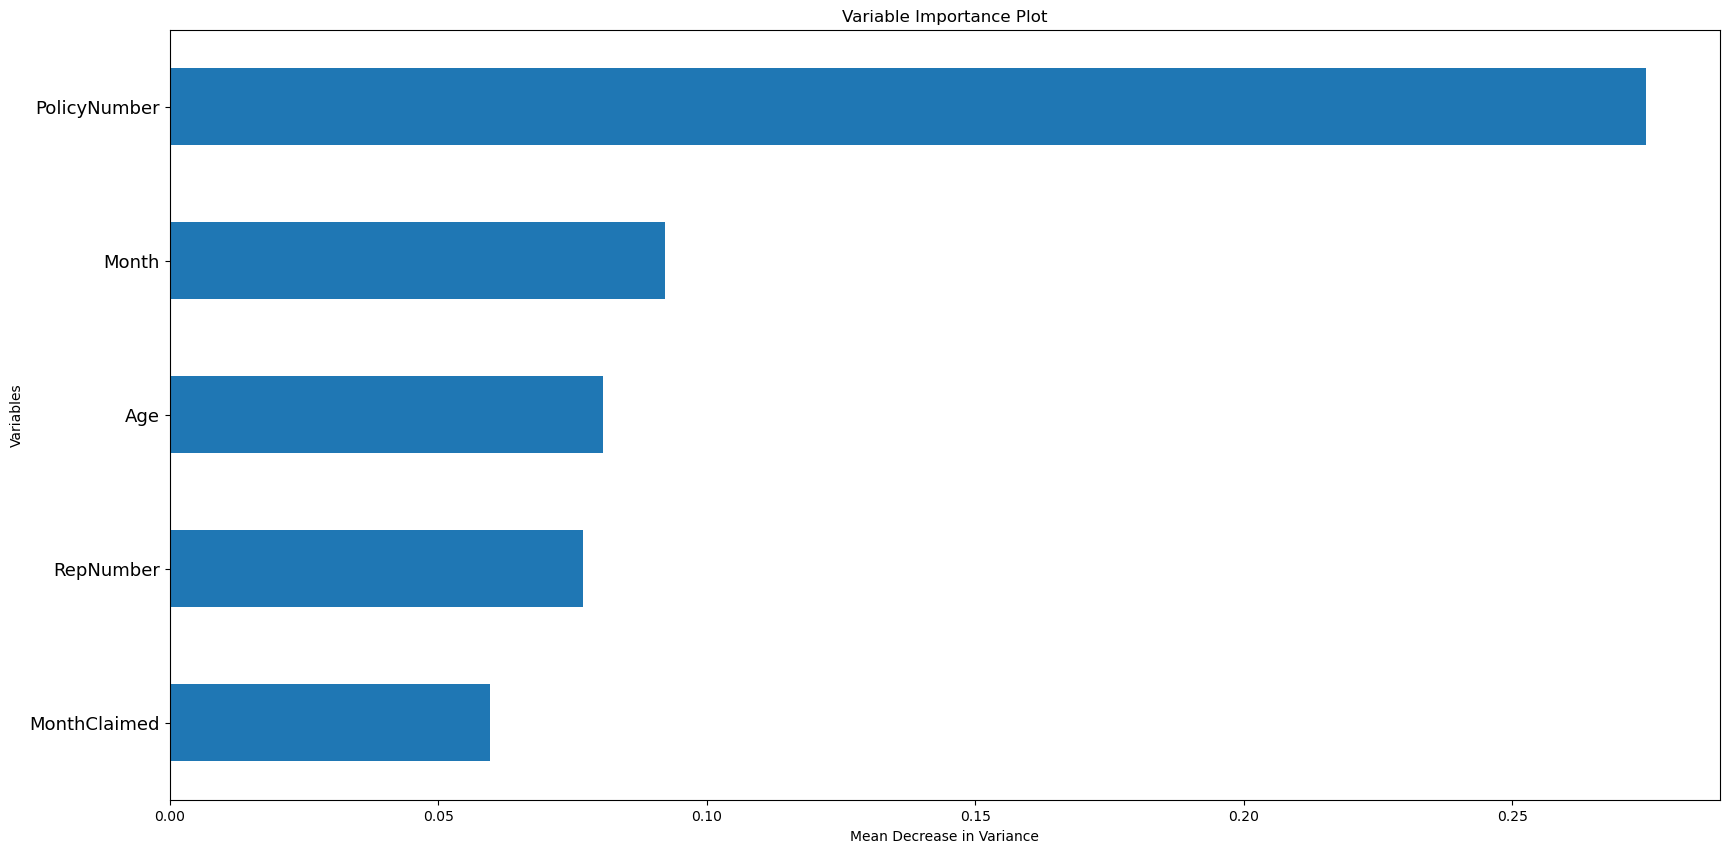

Variables
PolicyNumber    0.274883
Month           0.092134
Age             0.080612
RepNumber       0.076889
MonthClaimed    0.059717
Name: Importance, dtype: float64


In [17]:
# Feature Importance Plot
model_ranks = pd.Series(ada_fit.feature_importances_, index=x_train.columns, name='Importance').sort_values(ascending=False, inplace=False)
model_ranks.index.name = 'Variables'
top_features = model_ranks.iloc[:5].sort_values(ascending=True, inplace=False)
plt.figure(figsize=(20,10))
ax = top_features.plot(kind='barh')
ax.set_title('Variable Importance Plot')
ax.set_xlabel('Mean Decrease in Variance')
ax.set_yticklabels(top_features.index, fontsize=13)
plt.show()

print(top_features.sort_values(ascending=False))

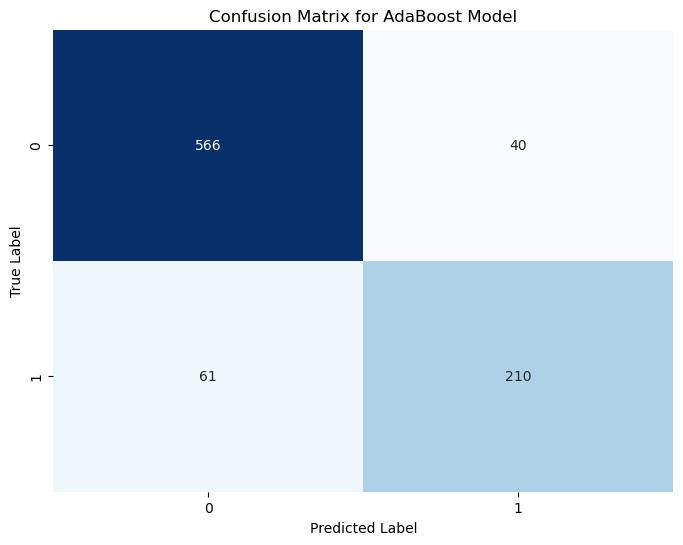

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.show()

# Evaluate the model and plot confusion matrix
y_pred = best_ada.predict(x_test)
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix for AdaBoost Model')


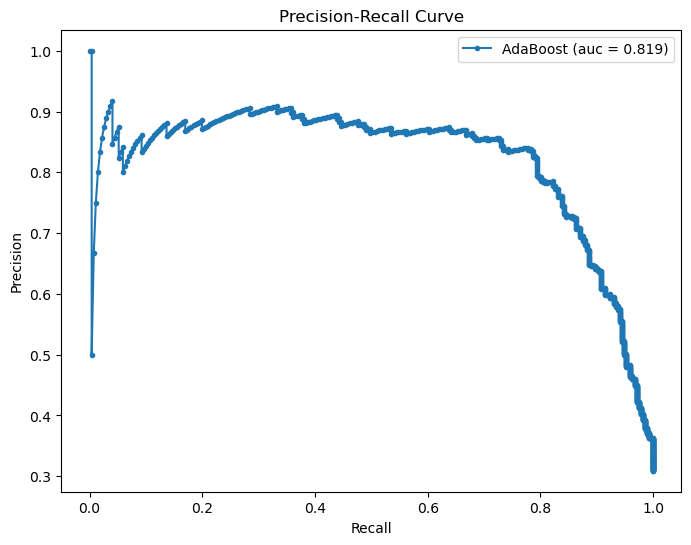

In [21]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

def plot_precision_recall_curve(y_true, y_scores, title='Precision-Recall Curve'):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    auc_score = auc(recall, precision)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='AdaBoost (auc = %0.3f)' % auc_score)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.title(title)
    plt.show()

# Calculate scores and plot precision-recall curve
y_scores = best_ada.decision_function(x_test)
plot_precision_recall_curve(y_test, y_scores)
